# Objetivo: Verificar se existe diferença nas notas dos alunos ao longo de 4 meses 


### Variaveis:

In [889]:
#Escola = 15 escolas diferentes
#estudante = numeros de estudantes
#mês = periodo observado (4 meses)
#ativ = Se o aluno faz atividade complementar
#texp = Periodo de experiencia dos professores nas escolas
#desempenho = Notas dos alunos de 0 a 100 (variavel target)

In [890]:
import multilevel_py
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [891]:
# Carregando o dataset
dados = pd.read_csv('tempo_estudante_escola.csv',encoding='latin1',sep=',')
x = dados[['escola','estudante','mes','ativ','texp']]
y = dados.desempenho
dados

,escola,estudante,mes,desempenho,ativ,texp
0,1,1,1,35.400002,não,2
1,1,1,2,44.400002,não,2
2,1,1,3,46.400002,não,2
3,1,1,4,52.400002,não,2
4,1,2,1,74.900002,não,2
...,...,...,...,...,...,...
2435,15,609,4,100.000000,sim,9
2436,15,610,1,87.599998,sim,9
2437,15,610,2,92.599998,sim,9
2438,15,610,3,94.599998,sim,9


# Analise Exploratoria

In [892]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2440 entries, 0 to 2439
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   escola      2440 non-null   int64  
 1   estudante   2440 non-null   int64  
 2   mes         2440 non-null   int64  
 3   desempenho  2440 non-null   float64
 4   ativ        2440 non-null   object 
 5   texp        2440 non-null   int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 114.5+ KB


### Dados Numericos

In [893]:
dados.describe()

,escola,estudante,mes,desempenho,texp
count,2440.000000,2440.000000,2440.000000,2440.000000,2440.000000
mean,8.485246,305.500000,2.500000,68.341352,9.027869
std,4.386862,176.127691,1.118263,22.981531,7.655618
min,1.000000,1.000000,1.000000,10.500000,2.000000
25%,5.000000,153.000000,1.750000,49.574999,2.000000
50%,9.000000,305.500000,2.500000,70.300003,9.000000
75%,12.000000,458.000000,3.250000,88.500000,18.000000
max,15.000000,610.000000,4.000000,100.000000,20.000000


### Dados Categoricos

In [894]:
dados.ativ.value_counts()


sim    1320
não    1120
Name: ativ, dtype: int64

In [895]:
dados.escola.value_counts()

12    248
11    228
15    212
13    212
5     192
3     192
1     188
9     176
8     140
10    132
6     120
7     112
14    108
2     100
4      80
Name: escola, dtype: int64

## Estudo sobre o balanceamento dos dados em relação à quantidade de alunos por período analisado

In [896]:
dados.groupby(dados['mes'])['estudante'].count()

mes
1    610
2    610
3    610
4    610
Name: estudante, dtype: int64

**Podemos observar que temos balanceamento longitudinal**

## Estudo sobre o desbalanceamento da quantidade de alunos aninhados em escolas

In [897]:
alunos_escolas = dados.groupby(dados['escola'])['estudante'].count()
alunos_escolas2 = alunos_escolas/4 # Como temos 4 meses os alunos se repentem 4 vezes , para ter a conclusão da quantidade de alunos por escola dividimos por 4
alunos_escolas2

escola
1     47.0
2     25.0
3     48.0
4     20.0
5     48.0
6     30.0
7     28.0
8     35.0
9     44.0
10    33.0
11    57.0
12    62.0
13    53.0
14    27.0
15    53.0
Name: estudante, dtype: float64

## Gráfico da evolução temporal média do desempenho escolar dos estudantes (ajuste linear)

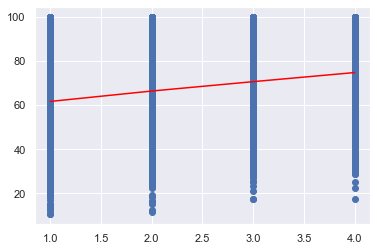

In [898]:
media_escola= pd.DataFrame(dados.groupby('mes').desempenho.mean())
plt.scatter(dados.mes,dados.desempenho)
plt.plot(media_escola.desempenho,c='red')

**Podemos observar que a medida que os meses passam a media do desempenho dos alunos tambem aumentam**

## Kernel density estimation (KDE) - função densidade de probabilidade da variável Target (desempenho), com histograma

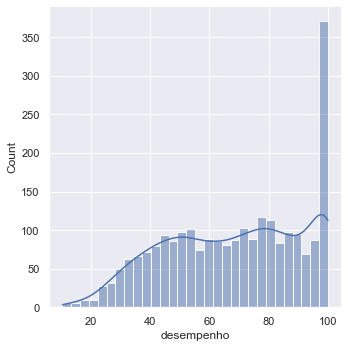

In [899]:
import seaborn as sns
sns.displot(dados.desempenho,kde=True,bins=30)

**Pergunta: Tem alguma escola especifica que faz com que os alunos tirem 100 no desempenho?**

## Kernel density estimation (KDE) - função densidade de probabilidade da variável Target (desempenho), com histograma

<AxesSubplot:xlabel='desempenho', ylabel='Density'>

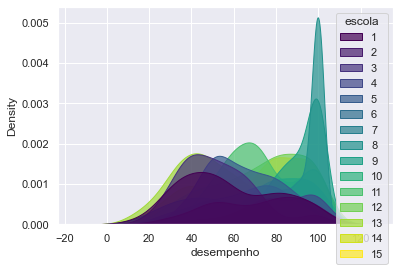

In [900]:
sns.kdeplot(data=dados, x="desempenho", hue="escola",fill='escola',palette="viridis",alpha=.7)

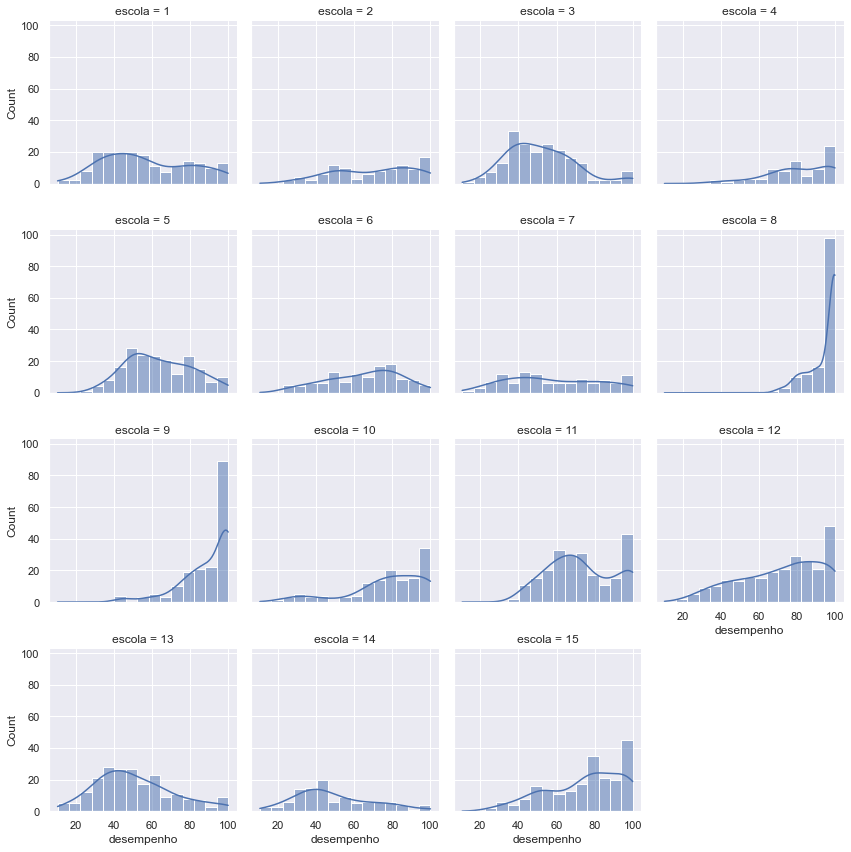

In [901]:
sns.displot(dados, x="desempenho", col="escola",kde=True,bins=15,col_wrap=4, height=3)

**A Escola 8 e 9 tem um desempenho melhor que as outras escolas**

## Variável Target (desempenho) em relação ao mês

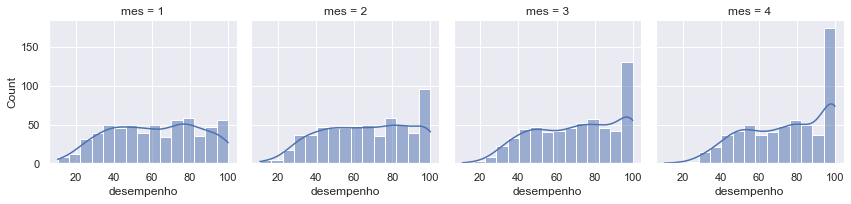

In [902]:
sns.displot(dados, x="desempenho", col="mes",kde=True,bins=15,col_wrap=4, height=3)

**Podemos observar que o periodo 3 e 4 são os que mais os estudantes tiram notas altas**

## Gráfico da evolução temporal do desempenho médio por escola (ajustes lineares)

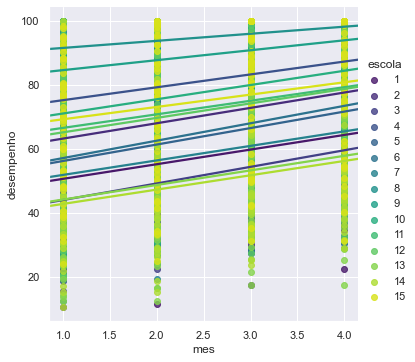

In [903]:
import seaborn as sns
sns.set_theme(color_codes=True)
ax = sns.lmplot(x="mes", y="desempenho", hue="escola", data=dados,palette='viridis',truncate=False,ci=0)

# ESTIMAÇÃO DO MODELO NULO HLM3 

### Objetivo: Verificar se existe diferenças entre o desempenhos dos alunos ao longo do tempo , entre alunos e entre alunos de escolas destintas

In [904]:
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM as bgmm

In [1032]:
#Parametros para definição dos niveis

# Para dizer ao modelo que uma variável é categórica, ela precisa ser embrulhada em C(independent_variable)
vcf = {"estudante": "0 + C(estudante)", "escola": "0 + C(escola)"} #nivel 2 = estudante , nivel 3 = escola
nivel_3 = dados["escola"]

In [1033]:
import statsmodels.formula.api as smf
from patsy import dmatrices
formula = "desempenho ~ 1"
md  = smf.mixedlm(formula, dados, groups=nivel_3);
mdf = md.fit();
print(mdf.summary());

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: desempenho 
No. Observations: 2440    Method:             REML       
No. Groups:       15      Scale:              361.4023   
Min. group size:  80      Log-Likelihood:     -10678.2523
Max. group size:  248     Converged:          Yes        
Mean group size:  162.7                                  
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      68.731    3.553 19.347 0.000 61.769 75.694
Group Var     186.827    3.771                           



Formula: desempenho~1+(1|estudante)+(1|escola)

Family: gaussian	 Inference: parametric

Number of observations: 2440	 Groups: {'estudante': 610.0, 'escola': 15.0}

Log-likelihood: -9092.139 	 AIC: 18184.277

Random effects:

                  Name      Var     Std
estudante  (Intercept)  325.799  18.050
escola     (Intercept)  180.193  13.424
Residual                 41.649   6.454

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),68.714,61.75,75.678,3.553,13.982,19.339,0.0,***


SS Type III Analysis of Variance Table with Satterthwaite approximated degrees of freedom:
(NOTE: Using original model contrasts, orthogonality not guaranteed)


,SS,MS,NumDF,DenomDF,F-stat,P-val,Sig


<AxesSubplot:xlabel='Estimate'>

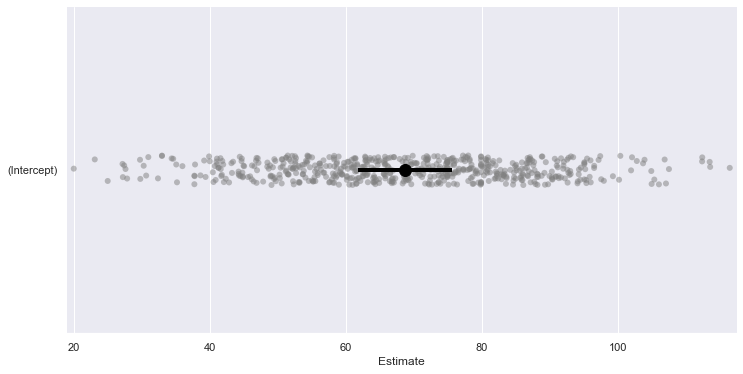

In [907]:
from pymer4.models import Lmer 
model = Lmer("desempenho ~ 1 + (1|estudante) + (1|escola)", data=dados)

display(model.fit())
# ANOVA results from fitted model
display(model.anova())
# Plot estimated model coefficients 
model.plot_summary()

# P-value dos parametros

### Intercepto

In [908]:
round(mdf.pvalues,3)

Intercept        0.000
escola Var       0.012
estudante Var    0.000
dtype: float64

**Os efeito aleatorio de intercepto de aluno e escola ao longo do tempo são estatisticamente significantes a um nivel de significancia de 5%**

# Parametros das variaveis Fixas

### Intercepto

In [909]:
mdf.fe_params

Intercept    68.713957
dtype: float64

# Significancia estatistica dos efeitos aleatorios

### Intercepto Escola

In [910]:
mdf.vcomp[0]

180.22235673700325

### Intercepto Aluno

In [911]:
mdf.vcomp[1]

325.79788292294785

### Variancia E(erro) do efeito aleatorio

In [912]:
mdf.scale

41.6493903375379

# Calculo do ICC (3 niveis)

### Escola

In [913]:
# Calculo do ICC - Intraclass Correlation
# Calcula a variaçao explicada da y em relaçao a variavel X
#Proporçao da variancia do nivel escola em relaçao a variancia total dos termos de erro

#Formula : 
t00k = mdf.vcomp[0] # Efeito aleatorio de intercpto nivel escola
v0jk = mdf.vcomp[1] # Efeito aleatorio de intercpto nivel Aluno
E = mdf.scale # Variancia E(erro) do efeito aleatorio do nivel individuo
icc_escola = t00k /(t00k + v0jk + E)
print(f'ICC_escola= {round(icc_escola*100)}%')

ICC_escola= 33%


**33% da variação do desempenho ao longo do tempo é devido a variavel escola**

### Aluno

In [914]:
# Calculo do ICC - Intraclass Correlation
# Calcula a variaçao explicada da y em relaçao a variavel X
#Proporçao da variancia do nivel escola em relaçao a variancia total dos termos de erro

#Formula : 
t00k = mdf.vcomp[0] # Efeito aleatorio de intercpto nivel escola
v0jk = mdf.vcomp[1] # Efeito aleatorio de intercpto nivel Aluno
E = mdf.scale # Variancia E(erro) do efeito aleatorio do nivel individuo
icc_aluno = v0jk /(v0jk + t00k + E)
print(f'ICC_aluno= {round(icc_aluno*100)}%')

ICC_aluno= 59%


**59% da variação do desempenho ao longo do tempo é devido a variavel Aluno**

### Tempo

In [915]:
total = 1
icc_escola 
icc_aluno
icc_tempo = total -(icc_escola + icc_aluno)
print(f'ICC_tempo= {round(icc_tempo*100)}%')

ICC_tempo= 8%


**8% da variação do desempenho ao longo do tempo é devido a variavel Tempo**

## ESTIMAÇÃO DO MODELO NULO OLS

In [916]:
import statsmodels.api as sm
x_interc = sm.add_constant(x) # Somente o Intercept
modelo = sm.OLS(y,x_interc[['const']]) # funçao 
resultado = modelo.fit() # Treinar o modelo
resultado.summary() # Verificar os dados do modelo

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 13 Oct 2021   Prob (F-statistic):                nan
Time:                        14:25:08   Log-Likelihood:                -11110.
No. Observations:                2440   AIC:                         2.222e+04
Df Residuals:                    2439   BIC:                         2.223e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         68.3414      0.465    146.892      0.000      67.429      69.254
==============================================================================
Omnibus:                      742.376   Durbin-Watson:                   0.440
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.934
Skew:                          -0.230   Prob(JB):                     8.25e-30
Kurtosis:                       1.949   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## COMPARAÇÃO DO HLM3 NULO COM UM OLS NULO  

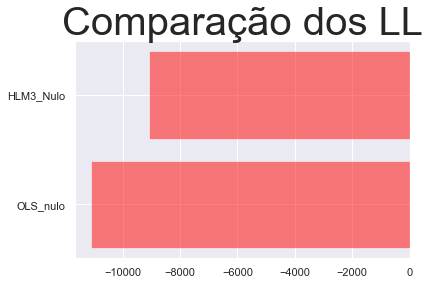

In [917]:
#Criar um dataFrame com os LLs
a = ['HLM3_Nulo','OLS_nulo']
b = [mdf.llf,resultado.llf]
dados_grafico = pd.DataFrame(a,b)
dados_grafico= dados_grafico.reset_index()
dados_grafico.columns=['Index','Modelo']

#Plotar no Grafico 
df_ordenado = dados_grafico.sort_values(by='Index',ascending=True)
plt.barh(df_ordenado.Modelo, df_ordenado.Index, color='red', alpha=0.5)
plt.title('Comparação dos LL',size=40,);

**Como os interceptos do modelo multinivel foi estatisticamente significantes o LL do modelo OLS não será superior**

## ESTIMAÇÃO DO MODELO HLM3 COM TENDÊNCIA LINEAR E INTERCEPTOS E INCLINAÇÕES ALEATÓRIOS 

### Objetivo: Verificar a significancia estatistica das escola(nivel 3) e dos alunos(nivel 2) em relaçao ao desempenho(Target) e o periodo(Variavel preditora)

In [859]:
t00k =intercepto escola  
t10k = inclinaçao ao longo do tempo(mes) em relaçao a escola
v0jk = intercepto alunos
v1jk = inclinaçao ao longo do tempo(mes) em relaçao a aluno 

SyntaxError: invalid syntax (<ipython-input-859-5ff45551a191>, line 1)

In [938]:
#Parametros para definição dos niveis
vcf = {"estudante": "0 + C(estudante)","escola": "0 + C(escola)"} #nivel 2 = estudante , nivel 3 = escola
nivel_2 = "estudante" 
nivel_3 = "escola" 
formula = "desempenho ~ mes"
re_f = "~ mes "


In [940]:
md1  = smf.mixedlm(formula, dados, groups=nivel_3,vc_formula=vcf);
mdf1 = md1.fit();
print(mdf1.summary());

          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: desempenho
No. Observations:  2440    Method:             REML      
No. Groups:        15      Scale:              10.1462   
Min. group size:   80      Log-Likelihood:     -7801.4202
Max. group size:   248     Converged:          Yes       
Mean group size:   162.7                                 
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      57.844    3.558 16.256 0.000 50.870 64.818
mes             4.348    0.058 75.386 0.000  4.235  4.461
escola Var    180.430   22.614                           
estudante Var 333.663    7.044                           



Formula: desempenho~mes+(mes|estudante)+(mes|escola)

Family: gaussian	 Inference: parametric

Number of observations: 2440	 Groups: {'estudante': 610.0, 'escola': 15.0}

Log-likelihood: -7411.506 	 AIC: 14823.013

Random effects:

                  Name      Var     Std
estudante  (Intercept)  388.978  19.723
estudante          mes    3.325   1.823
escola     (Intercept)  225.494  15.016
escola             mes    0.553   0.744
Residual                  3.795   1.948

                   IV1  IV2   Corr
estudante  (Intercept)  mes -0.414
escola     (Intercept)  mes -0.880

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),57.856,50.077,65.635,3.969,13.992,14.578,0.0,***
mes,4.337,3.925,4.748,0.210,13.819,20.663,0.0,***


SS Type III Analysis of Variance Table with Satterthwaite approximated degrees of freedom:
(NOTE: Using original model contrasts, orthogonality not guaranteed)


,SS,MS,NumDF,DenomDF,F-stat,P-val,Sig
0,1620.354493,1620.354493,1,13.819051,426.96529,8.703592e-12,***


<AxesSubplot:xlabel='Estimate'>

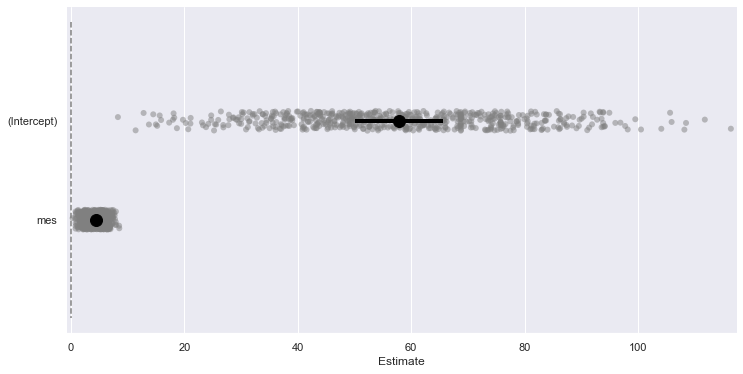

In [920]:
model1 = Lmer("desempenho ~ mes + (mes|estudante) + (mes|escola)", data=dados)

display(model1.fit())
# ANOVA results from fitted model
display(model1.anova())
# Plot estimated model coefficients 
model1.plot_summary()

## COMPARAÇÃO DOS LOGLIKES ENTRE OS MODELOS

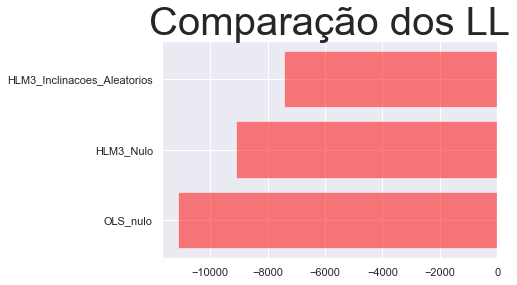

In [921]:
#Criar um dataFrame com os LLs
a = ['HLM3_Nulo','OLS_nulo','HLM3_Inclinacoes_Aleatorios']
b = [mdf.llf,resultado.llf,model1.logLike]
dados_grafico = pd.DataFrame(a,b)
dados_grafico= dados_grafico.reset_index()
dados_grafico.columns=['Index','Modelo']

#Plotar no Grafico 
df_ordenado = dados_grafico.sort_values(by='Index',ascending=True)
plt.barh(df_ordenado.Modelo, df_ordenado.Index, color='red', alpha=0.5)
plt.title('Comparação dos LL',size=40,);

## ESTIMAÇÃO DO MODELO HLM3 COM TENDÊNCIA LINEAR,INTERCEPTOS E INCLINAÇÕES ALEATÓRIOS E AS VARIÁVEIS 'ativ' DE NÍVEL 2 E 'texp' DE NÍVEL 3

In [931]:
#Parametros para definição dos niveis
vcf = {"estudante": "0 + C(estudante)","escola": "0 + C(escola)"} #nivel 2 = estudante , nivel 3 = escola
nivel_2 = "estudante" 
nivel_3 = "escola" 
formula = "desempenho ~ mes + ativ + texp + ativ:mes + texp:mes + (mes|estudante) + (mes|escola)"
re_f = "~ mes "

In [932]:
md2  = smf.mixedlm(formula, dados, groups=nivel_3,vc_formula=vcf);
mdf2 = md2.fit();
print(mdf2.summary());

           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  desempenho
No. Observations:  2440     Method:              REML      
No. Groups:        15       Scale:               9.5913    
Min. group size:   80       Log-Likelihood:      -7722.6790
Max. group size:   248      Converged:           Yes       
Mean group size:   162.7                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        41.765    4.897  8.529 0.000 32.168 51.362
ativ[T.sim]      14.831    1.690  8.774 0.000 11.518 18.144
mes               5.188    0.098 52.708 0.000  4.995  5.381
ativ[T.sim]:mes  -0.695    0.119 -5.857 0.000 -0.928 -0.463
texp              1.194    0.333  3.587 0.000  0.541  1.846
texp:mes         -0.047    0.008 -6.085 0.000 -0.062 -0.032
mes | estudante  -0.005    0.014 -0.363 0.716 -0.03

Formula: desempenho~mes+ativ+texp+ativ:mes+texp:mes+(mes|estudante)+(mes|escola)

Family: gaussian	 Inference: parametric

Number of observations: 2440	 Groups: {'estudante': 610.0, 'escola': 15.0}

Log-likelihood: -7376.715 	 AIC: 14753.429

Random effects:

                  Name      Var     Std
estudante  (Intercept)  350.918  18.733
estudante          mes    3.258   1.805
escola     (Intercept)   88.720   9.419
escola             mes    0.255   0.505
Residual                  3.795   1.948

                   IV1  IV2   Corr
estudante  (Intercept)  mes -0.392
escola     (Intercept)  mes -0.669

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),40.032,32.455,47.609,3.866,14.196,10.356,0.000,***
mes,5.168,4.692,5.643,0.243,16.504,21.297,0.000,***
ativsim,14.702,11.183,18.221,1.796,606.754,8.188,0.000,***
texp,1.179,0.501,1.857,0.346,13.133,3.408,0.005,**
mes:ativsim,-0.652,-1.014,-0.290,0.185,514.046,-3.529,0.000,***
mes:texp,-0.057,-0.098,-0.015,0.021,13.709,-2.698,0.018,*


SS Type III Analysis of Variance Table with Satterthwaite approximated degrees of freedom:
(NOTE: Using original model contrasts, orthogonality not guaranteed)


,SS,MS,NumDF,DenomDF,F-stat,P-val,Sig
0,1638.737579,1638.737579,1,14.447820,431.811351,3.620141e-12,***
1,254.439458,254.439458,1,606.753666,67.045418,1.570340e-15,***
2,44.069926,44.069926,1,13.133263,11.612533,4.610834e-03,**
3,47.265945,47.265945,1,514.045964,12.454692,4.543524e-04,***
4,27.622037,27.622037,1,13.708521,7.278474,1.758681e-02,*


<AxesSubplot:xlabel='Estimate'>

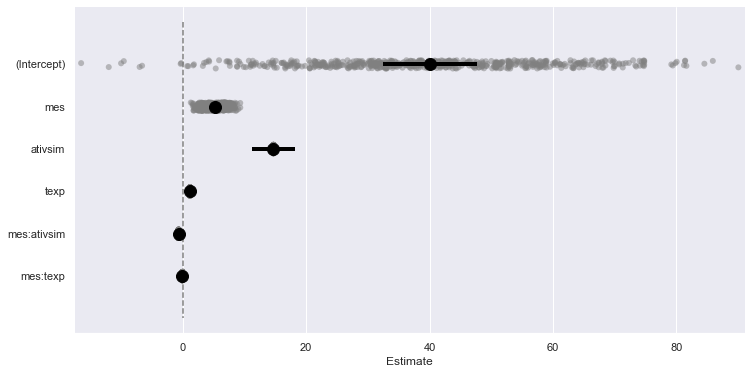

In [922]:
model2 = Lmer("desempenho ~ mes + ativ + texp + ativ:mes + texp:mes + (mes|estudante) + (mes|escola)", data=dados)

display(model2.fit())
# ANOVA results from fitted model
display(model2.anova())
# Plot estimated model coefficients 
model2.plot_summary()

**Todos os p_values são estatisticamentes significantes**

## COMPARAÇÃO DOS LOGLIKES ENTRE OS MODELOS

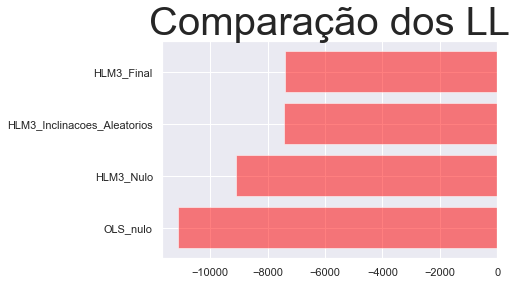

In [956]:
#Criar um dataFrame com os LLs
a = ['HLM3_Nulo','OLS_nulo','HLM3_Inclinacoes_Aleatorios','HLM3_Final']
b = [mdf.llf,resultado.llf,model1.logLike,model2.logLike]
dados_grafico = pd.DataFrame(a,b)
dados_grafico= dados_grafico.reset_index()
dados_grafico.columns=['Index','Modelo']

#Plotar no Grafico 
df_ordenado = dados_grafico.sort_values(by='Index',ascending=True)
plt.barh(df_ordenado.Modelo, df_ordenado.Index, color='red', alpha=0.5)
plt.title('Comparação dos LL',size=40,);

# Previsão 

### Sem Algoritimo

In [942]:
#Prever a linha 0
x.iloc[0,:]

escola         1
estudante      1
mes            1
ativ         não
texp           2
Name: 0, dtype: object

In [943]:
# Variaveis preditoras
escola = 1
estudante = 1
mes = 1
ativ = 0
texp = 2

In [951]:
#Parametros fixos
model2.coefs

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),40.032209,32.455419,47.608999,3.865780,14.195706,10.355531,5.312003e-08,***
mes,5.167527,4.691949,5.643105,0.242646,16.504409,21.296535,1.951219e-13,***
ativsim,14.702146,11.182943,18.221348,1.795545,606.753666,8.188127,1.570340e-15,***
texp,1.178654,0.500746,1.856563,0.345878,13.133263,3.407717,4.610834e-03,**
mes:ativsim,-0.651887,-1.013925,-0.289849,0.184717,514.045964,-3.529121,4.543524e-04,***
mes:texp,-0.056649,-0.097805,-0.015494,0.020998,13.708521,-2.697865,1.758681e-02,*


In [976]:
# Fixos
Intercept = 40.032209
mes_param = 5.167527
ativsim_param = 14.702146
texp_param = 1.178654
mes_ativsim_param = -0.651887
mes_texp_param = -0.056649

prev_lin0_fixos = Intercept + mes_param*mes + ativsim_param*ativ + texp_param*texp + mes_ativsim_param*mes*ativ + mes_texp_param*texp*mes
print(f'A previsão do desempenho do aluno_0 no mes 1 usando somente efeitos fixos = {prev_lin0_fixos}')

A previsão do desempenho do aluno_0 no mes 1 usando somente efeitos fixos = 47.443746000000004


In [966]:
#Parametros Aleatorio estudante
model2.ranef[0]


,X.Intercept.,mes
1,-8.671653,0.319513
2,31.264122,-2.690180
3,27.925868,0.155623
4,-3.881368,-2.696019
5,19.467712,1.711604
...,...,...
606,-11.912358,-2.654590
607,15.575296,0.459043
608,2.006972,0.662649
609,-0.544682,3.313821


In [970]:
#Parametros Aleatorio Escola
aleat_escola = model2.ranef[1]
aleat_escola

,X.Intercept.,mes
1,-2.182040,-0.118651
2,6.822175,-0.040966
3,-8.109579,0.319766
4,4.958146,-0.070611
5,0.486323,0.320377
6,0.191633,0.437460
7,-2.667478,-0.052807
8,9.726936,-0.802748
9,7.497770,-0.396260
10,16.113051,-0.384259


In [977]:
#Parametros
estudante_inter = -8.671653
estudante_mes = 0.319513
escola_inter = -2.182040
escola_mes = -0.118651

#Previsao Final linha 0 
prev_aleat = prev_lin0_fixos + (estudante_inter + estudante_mes*mes + escola_inter + escola_mes*mes)
print(f'A previsão do desempenho do aluno_0 no mes 1 usando efeitos fixos + Aleatorios = {prev_aleat}')

A previsão do desempenho do aluno_0 no mes 1 usando efeitos fixos + Aleatorios = 36.790915000000005


In [979]:
#Previsao a ser encontrada (35.4000015258789)
y.iloc[0]

35.4000015258789

### Grafico dos parametros da variavel Escola

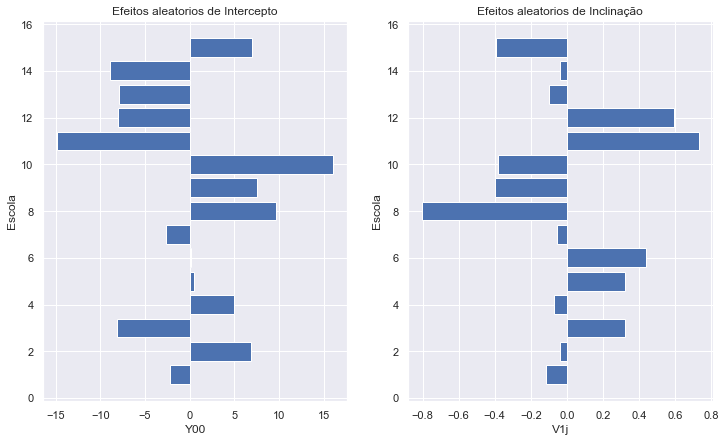

In [974]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,7))
a = np.arange(len(aleat_escola))+1
b = aleat_escola.iloc[:,0]
ax1.barh(a,b);
ax1.set(title="Efeitos aleatorios de Intercepto", xlabel="Y00", ylabel="Escola")
plt.gca().invert_yaxis()


a1 = np.arange(len(aleat_escola))+1
b1 = aleat_escola.mes
ax2.barh(a1,b1);
ax2.set(title="Efeitos aleatorios de Inclinação", xlabel="V1j", ylabel="Escola")
plt.gca().invert_yaxis()

**Podemos observar que a escola 10 apresenta o maior impacto de influencia positiva para o intercepto do modelo no desempenho dos alunos e a escola 11 a menor, porém quando observamos os efeitos aleatorios ao longo dos mêses a escola 11 é a maior**

## COMPARAÇÃO COM UM MODELO OLS COM DUMMIES  

### 1° Criar as Dummies

In [1003]:
# Excluir a variavel estudante
x_vars = x.drop(columns=['estudante'])
x_vars

,escola,mes,ativ,texp
0,1,1,não,2
1,1,2,não,2
2,1,3,não,2
3,1,4,não,2
4,1,1,não,2
...,...,...,...,...
2435,15,4,sim,9
2436,15,1,sim,9
2437,15,2,sim,9
2438,15,3,sim,9


In [1004]:
# Criar as dummies
Dummies_escola = pd.get_dummies(dados['escola'])
Dummies_escola = Dummies_escola.iloc[:,1:]
x_vars  = x_vars.join(Dummies_escola)
Dummies_ativ = pd.get_dummies(dados['ativ'])
Dummies_ativ = Dummies_ativ.iloc[:,1:]
x_vars['ativ_sim'] = Dummies_ativ
x_vars = x_vars.drop(columns=['ativ'])
x_vars.head(5)

,escola,mes,texp,2,3,4,5,6,7,8,9,10,11,12,13,14,15,ativ_sim
0,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [1007]:
x_vars['ativ_mes'] = x_vars.ativ_sim*x_vars.mes
x_vars['texp_mes'] = x_vars.texp*x_vars.mes
x_vars

,escola,mes,texp,2,3,4,5,6,7,8,9,10,11,12,13,14,15,ativ_sim,ativ_mes,texp_mes
0,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
1,1,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
2,1,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
3,1,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
4,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2435,15,4,9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,4,36
2436,15,1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,9
2437,15,2,9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,18
2438,15,3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3,27


## Modelo OLS

In [1008]:
#Modelo OLS
import statsmodels.api as sm
x_constante = sm.add_constant(x_vars)
y = dados['desempenho'].values
modelo = sm.OLS(y,x_constante)
modelo_v1 = modelo.fit()
modelo_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     98.22
Date:                Wed, 13 Oct 2021   Prob (F-statistic):          6.83e-272
Time:                        15:47:36   Log-Likelihood:                -10441.
No. Observations:                2440   AIC:                         2.092e+04
Df Residuals:                    2421   BIC:                         2.103e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.7424      1.999     18.382      0.000      32.823      40.662
escola         0.0725      0.133      0.544      0.587      -0.189       0.334
mes            5.1621      0.547      9.446      0.000       4.090       6.234
texp           1.3648      0.121     11.235      0.000       1.127       1.603
2             10.8349      2.105      5.147      0.000       6.707      14.963
3             -5.2040      1.637     -3.179      0.001      -8.415      -1.993
4              7.1001      2.103      3.377      0.001       2.977      11.223
5              2.7066      1.502      1.802      0.072      -0.238       5.651
6              4.4554      1.715      2.598      0.009       1.093       7.818
7             -0.9749      1.694     -0.575      0.565      -4.297       2.347
8              6.7430      1.263      5.340      0.000       4.267       9.219
9              5.5073      1.160      4.747      0.000       3.232       7.782
10            19.3531      1.422     13.613      0.000      16.565      22.141
11           -15.4563      1.088    -14.209      0.000     -17.589     -13.323
12            -8.1240      1.097     -7.408      0.000     -10.275      -5.973
13            -7.0274      1.131     -6.211      0.000      -9.246      -4.809
14            -8.9758      1.371     -6.546      0.000     -11.665      -6.287
15             6.7037      1.228      5.459      0.000       4.296       9.112
ativ_sim      14.7923      1.877      7.881      0.000      11.112      18.473
ativ_mes      -0.7069      0.671     -1.054      0.292      -2.022       0.608
texp_mes      -0.0478      0.044     -1.095      0.274      -0.133       0.038
==============================================================================
Omnibus:                        7.319   Durbin-Watson:                   0.533
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                7.394
Skew:                          -0.129   Prob(JB):                       0.0248
Kurtosis:                       2.925   Cond. No.                     1.22e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.01e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""